In [1]:
#%matplotlib inline
%matplotlib notebook
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad

from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit

In [2]:
path = "/data/POL/HALOB/output_00417"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False)

loading Dark matter..
beware no clump info:
maybe is a very early snapshot or an old Ramses simulation
loading Stars..
loading Gas..


In [3]:
ok,rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)
centro_rho = myhalo.st.pos3d[np.where(rho == rho.max())][0]
print "density",centro_rho
myhalo.center_shift(centro_rho)

density [ 6808.77539062  6947.90380859  6901.91210938]


In [4]:
myhalo.r_virial(600)

| r_200 = 186.9140625
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  8.201e+11 M_sun
| p_dm_200      =  3.553e+06 particles
| stellar mass  =  7.992e+10 M_sun
| p_st_200      =  2.162e+06 psrticles
| gas mass      =  8.257e+10 M_sun
| p_gs_200      =  8.341e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |15, 0, 0|
| D =| 0,12, 0|
|    | 0, 0, 1|


In [5]:
ok,rho_st,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)

In [6]:
ok,rho_dm,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32), myhalo.dm.mass)

# generate 2d density histogram

In [48]:
bins=20
print 10**1.3
xedges = np.logspace(-1,np.log10(25),bins)
yedges = np.linspace(-4,4,bins)
dens_hist = np.zeros([len(yedges)-1,len(xedges)-1])
print dens_hist.shape
for i in range(len(xedges[:-1])):
    for j in range(len(yedges[:-1])):
        Rcon = (myhalo.st.R >= xedges[i] )&(myhalo.st.R < xedges[i+1] )
        Zcon = (myhalo.st.pos3d[:,2] >= yedges[j])&(myhalo.st.pos3d[:,2] < yedges[j+1])
        mass = np.sum(myhalo.st.mass[np.where(Rcon&Zcon)])
        volume = np.pi * (yedges[j+1]-yedges[j]) * (xedges[i+1]**2 - xedges[i]**2)
        dens_hist [j][i] = mass / volume 
    


19.9526231497
(19, 19)


(array([9]), array([14]))


<IPython.core.display.Javascript object>


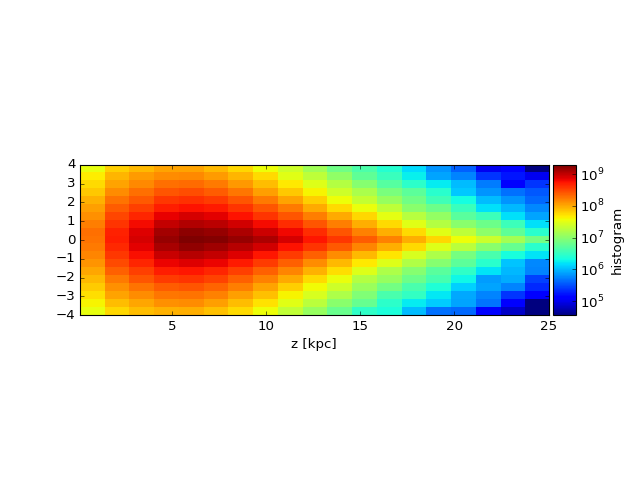

In [49]:
bins=20
xedges = np.logspace(-1,np.log10(25),bins)
yedges = np.linspace(-4,4,bins)

H, R, z = np.histogram2d(myhalo.st.R,myhalo.st.pos3d[:,2],bins=[xedges,yedges]) 
H = H.T
N = np.zeros(H.shape)
for i in range(len(H)):
    for j in range(len(H[0])):
        N[i,-(j+1)] = H[i,j]
        
        
H, R, z = np.histogram2d(myhalo.st.R,myhalo.st.pos3d[:,2],bins=[xedges,yedges],weights=myhalo.st.mass) 
H = H.T
M = np.zeros(H.shape)
for i in range(len(H)):
    for j in range(len(H[0])):
        M[i,-(j+1)] = H[i,j]

print np.where(H==H.max())
fig, ax = plt.subplots()
real =  ax.imshow(M, interpolation='nearest', origin='low',norm=mpl.colors.LogNorm(),
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax.set_xlabel("R [kpc]")
ax.set_xlabel("z [kpc]")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='histogram')

In [50]:
print np.sum(M)

74190681010.3


<IPython.core.display.Javascript object>


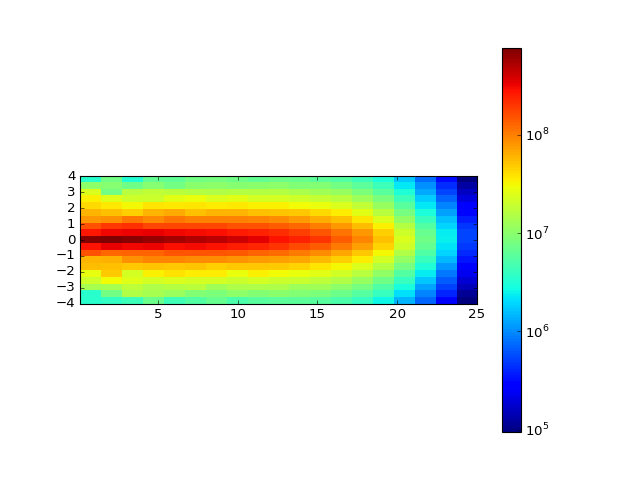

In [51]:

fig = plt.figure()
ax = fig.add_subplot()

real =  plt.imshow(dens_hist, interpolation='nearest', origin='low',norm=mpl.colors.LogNorm(),
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

cbar = plt.colorbar(real)

# McMillan fit



# Stars

In [52]:
def stars(R,z,B_0,r0,al,r_cut,q,D_0,z_d,Rd):
    def McMBulge(U,B_0,r0,al,r_cut):
        x = np.sqrt(U[0]**2 + (U[1]/q)**2)
        bulge = (10**B_0) * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge

    def McMDisc(x,z,z_d,D_0,Rd):
        disc = (10**D_0) * np.exp(- (abs(z) / z_d) - (x / Rd))
        return disc
    U = [R,z]
    return (McMBulge(U,B_0,r0,al,r_cut)+McMDisc(U[0],U[1],z_d,D_0,Rd))

R_array = (xedges[1:] + xedges[:-1])/2
Z_array = (yedges[1:] + yedges[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)


def chi2(B_0,r0,al,r_cut,q,D_0,z_d,Rd):
    chi2_array =np.array([])
    expected = stars(R,Z,B_0,r0,al,r_cut,q,D_0,z_d,Rd)
    observed = dens_hist
    c = (((observed))- (expected))**2 #/ H2
    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)# + diff**2)


def mass_check(B_0,r0,al,r_cut,q,D_0,z_d,Rd):
    bins = 101
    edge = 20
    zedge = edge/10.
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-zedge,zedge,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * stars(U[0],U[1],B_0,r0,al,r_cut,q,D_0,z_d,Rd)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhalo.st.mass[np.where((myhalo.st.R<50.)&(np.abs(myhalo.st.pos3d[:,2])<zedge))])
    diff = (data_in - F)**2
    return  diff

In [53]:
print len(R)

19


In [54]:


def m_int_check(B_0,r0,al,r_cut,q,D_0,z_d,Rd):
    def I(R,z,B_0,r0,al,r_cut,q,D_0,z_d,Rd):
        return 2. * np.pi * R * stars(R,z,B_0,r0,al,r_cut,q,D_0,z_d,Rd)
    final = 0
    for i in range(len(M)):
        for j in range(len(M[0])):
            integral = dblquad(I,z[i], z[i+1] , lambda x: R[j], lambda x: R[j+1],
                              args=(B_0,r0,al,r_cut,q,D_0,z_d,Rd),epsrel=1.e-3
                             )
            final+=np.abs(integral[0]-M[i,j])/N[i,j]
    return final
    

In [55]:
"""
mint=Minuit(m_int_check, 
         B_0=9.1, error_B_0=0.01,     limit_B_0=(8,12),
         r0=0.25,    error_r0=0.01,     limit_r0=(0.01,2.),
         al=1.8,     error_al=0.001,    limit_al=(0,2.),
         r_cut=5.5,  error_r_cut=0.01,   limit_r_cut=(5,6.5),
         q=0.3,      error_q=0.0001,     limit_q=(0,2.),
         D_0=2.1,    error_D_0=1e6,     limit_D_0=(0,30),
         z_d=1.8,  error_z_d=0.002,  limit_z_d=(0,6),
         Rd=100,     error_Rd=0.01,        limit_Rd=(4,20.),
         print_level=0)
mint.migrad();
mint.values
"""

'\nmint=Minuit(m_int_check, \n         B_0=9.1, error_B_0=0.01,     limit_B_0=(8,12),\n         r0=0.25,    error_r0=0.01,     limit_r0=(0.01,2.),\n         al=1.8,     error_al=0.001,    limit_al=(0,2.),\n         r_cut=5.5,  error_r_cut=0.01,   limit_r_cut=(5,6.5),\n         q=0.3,      error_q=0.0001,     limit_q=(0,2.),\n         D_0=2.1,    error_D_0=1e6,     limit_D_0=(0,30),\n         z_d=1.8,  error_z_d=0.002,  limit_z_d=(0,6),\n         Rd=100,     error_Rd=0.01,        limit_Rd=(4,20.),\n         print_level=0)\nmint.migrad();\nmint.values\n'

In [56]:
m1=Minuit(chi2, 
         B_0=9.1, error_B_0=0.1,     limit_B_0=(8,12),
         r0=0.25,    error_r0=0.1,     limit_r0=(0.01,2.),
         al=1.8,     error_al=0.1,    limit_al=(0,2.),
         r_cut=5.5,  error_r_cut=0.1,   limit_r_cut=(5,6.5),
         q=0.3,      error_q=0.1,     limit_q=(0,2.),
         D_0=2.1,    error_D_0=1e6,     limit_D_0=(0,30),
         z_d=1.8,  error_z_d=0.2,  limit_z_d=(0,6),
         Rd=100,     error_Rd=0.1,        limit_Rd=(4,20.))
#         print_level=0)
m1.migrad();

err = 0.1
upp = 1.1
low = 0.9
m2=Minuit(mass_check, 
         B_0=m1.values['B_0'], error_B_0=m1.values['B_0']*err, limit_B_0=(m1.values['B_0']*low,m1.values['B_0']*upp),
         r0=m1.values['r0'], error_r0=m1.values['r0']*err, limit_r0=(m1.values['r0']*low,m1.values['r0']*upp),
         al=m1.values['al'], error_al=m1.values['al']*err, limit_al=(m1.values['al']*low,m1.values['al']*upp),
         r_cut=m1.values['r_cut'],  error_r_cut=m1.values['r_cut']*err, limit_r_cut=(m1.values['r_cut']*low,m1.values['r_cut']*upp),
         q=m1.values['q'], error_q=m1.values['q']*err, limit_q=(m1.values['q']*low,m1.values['q']*upp),
         D_0=m1.values['D_0'], error_D_0=m1.values['D_0']*err, limit_D_0=(m1.values['D_0']*low,m1.values['D_0']*upp),
         z_d=m1.values['z_d'], error_z_d=m1.values['z_d']*err,  limit_z_d=(m1.values['z_d']*low,m1.values['z_d']*upp),
         Rd=m1.values['Rd'], error_Rd=m1.values['Rd']*err, limit_Rd=(m1.values['Rd']*low,m1.values['Rd']*upp))
#         print_level=0)

m2.migrad();

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: InitialParamWarning: errordef is not given. Default to 1.


FCN = 2.77243991578e+16 
 TOTAL NCALL = 1184 
 NCALLS = 1184 
 
 
 EDM = 322.149127585 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 8.86768 
 1.25864e-09 
 0 
 0 
 8.0 
 12.0 
 
 
 
 
 2 
 r0 
 0.603595 
 6.65675e-09 
 0 
 0 
 0.01 
 2.0 
 
 
 
 
 3 
 al 
 1.0152 
 5.35694e-09 
 0 
 0 
 0.0 
 2.0 
 
 
 
 
 4 
 r_cut 
 6.5 
 8.88178e-16 
 0 
 0 
 5.0 
 6.5 
 
 
 
 
 5 
 q 
 0.368918 
 1.1209e-09 
 0 
 0 
 0.0 
 2.0 
 
 
 
 
 6 
 D_0 
 8.1473 
 6.6447e-09 
 0 
 0 
 0.0 
 30.0 
 
 
 
 
 7 
 z_d 
 0.569801 
 5.85829e-09 
 0 
 0 
 0.0 
 6.0 
 
 
 
 
 8 
 Rd 
 5.9964 
 7.59894e-08 
 0 
 0 
 4.0 
 20.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 8.868e+00 & 1.259e-09 & & & 8.000e+00 & 1.200e+01 & \\
\hline
2 & r0 & 6.036e-01 & 6.657e-09 & & & 1.000e-02 & 2.000e+00 & \\
\hline
3 & al & 1.015e+00 & 5.357e-09 & & & 0.000e+00 & 2.000e+00 & \\
\hline
4 & $r_{cut}$ & 6.500e+00 & 8.882e-16 & & & 5.000e+00 & 6.500e+00 & \\
\hline
5 & q & 3.689e-01 & 1.121e-09 & & & 0.000e+00 & 2.000e+00 & \\
\hline
6 & $D_{0}$ & 8.147e+00 & 6.645e-09 & & & 0.000e+00 & 3.000e+01 & \\
\hline
7 & $z_{d}$ & 5.698e-01 & 5.858e-09 & & & 0.000e+00 & 6.000e+00 & \\
\hline
8 & Rd & 5.996e+00 & 7.599e-08 & & & 4.000e+00 & 2.000e+01 & \\
\hline
\end{tabular}

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: InitialParamWarning: errordef is not given. Default to 1.


FCN = 5.23868948221e-10 
 TOTAL NCALL = 173 
 NCALLS = 173 
 
 
 EDM = 5.12622172411e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 8.87196 
 1.37179e-11 
 0 
 0 
 7.98091011878 
 9.75444570073 
 
 
 
 
 2 
 r0 
 0.609622 
 2.05652e-11 
 0 
 0 
 0.543235502721 
 0.663954503326 
 
 
 
 
 3 
 al 
 1.01067 
 1.44975e-11 
 0 
 0 
 0.913675548675 
 1.11671455949 
 
 
 
 
 4 
 r_cut 
 6.53569 
 1.19305e-10 
 0 
 0 
 5.85 
 7.15 
 
 
 
 
 5 
 q 
 0.373818 
 1.85572e-11 
 0 
 0 
 0.332026614851 
 0.405810307041 
 
 
 
 
 6 
 D_0 
 8.15175 
 1.43672e-11 
 0 
 0 
 7.33257191842 
 8.96203234473 
 
 
 
 
 7 
 z_d 
 0.575562 
 2.00429e-11 
 0 
 0 
 0.512820769206 
 0.62678094014 
 
 
 
 
 8 
 Rd 
 6.03318 
 1.25124e-10 
 0 
 0 
 5.39676396053 
 6.59604484064 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 8.872e+00 & 1.372e-11 & & & 7.981e+00 & 9.754e+00 & \\
\hline
2 & r0 & 6.096e-01 & 2.057e-11 & & & 5.432e-01 & 6.640e-01 & \\
\hline
3 & al & 1.011e+00 & 1.450e-11 & & & 9.137e-01 & 1.117e+00 & \\
\hline
4 & $r_{cut}$ & 6.536e+00 & 1.193e-10 & & & 5.850e+00 & 7.150e+00 & \\
\hline
5 & q & 3.738e-01 & 1.856e-11 & & & 3.320e-01 & 4.058e-01 & \\
\hline
6 & $D_{0}$ & 8.152e+00 & 1.437e-11 & & & 7.333e+00 & 8.962e+00 & \\
\hline
7 & $z_{d}$ & 5.756e-01 & 2.004e-11 & & & 5.128e-01 & 6.268e-01 & \\
\hline
8 & Rd & 6.033e+00 & 1.251e-10 & & & 5.397e+00 & 6.596e+00 & \\
\hline
\end{tabular}

In [57]:
m1.values

{'B_0': 8.867677909750233,
 'D_0': 8.147302131577074,
 'Rd': 5.996404400584183,
 'al': 1.0151950540834869,
 'q': 0.36891846094603786,
 'r0': 0.603595003023478,
 'r_cut': 6.499999999999999,
 'z_d': 0.5698008546729423}

In [58]:
m2.values

{'B_0': 8.87195758403573,
 'D_0': 8.151747292675383,
 'Rd': 6.033178960382946,
 'al': 1.0106688841254605,
 'q': 0.3738180994608952,
 'r0': 0.6096217962517632,
 'r_cut': 6.535689115608522,
 'z_d': 0.5755622248594972}

In [41]:

bins = 101
edge = 5
zedge = edge/10.
xe = np.linspace(0,edge,bins)
ye = np.linspace(-zedge,zedge,bins)
R_test = (xe[1:] + xe[:-1])/2
Z_test = (ye[1:] + ye[:-1])/2
U = np.meshgrid(R_test,Z_test)
rho = 2. * np.pi * U[0] * stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                  m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])

def integrand(R,z,B_0,r0,al,r_cut,q,D_0,z_d,Rd):
    return 2. * np.pi * R * stars(R,z,B_0,r0,al,r_cut,q,D_0,z_d,Rd)

i = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
                                  m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd']))
j = dblquad(integrand, -zedge, zedge , lambda x: 0, lambda x: edge, args=(m1.values['B_0'], m1.values['r0'], m1.values['al'] , m1.values['r_cut'],
                                  m1.values['q'], m1.values['D_0'], m1.values['z_d'], m1.values['Rd']))

F = i[0]
F2 = j[0]
print "Fit  =  {0:.5e} dens constrain 1dn level fit".format(F2)
print "Fit  =  {0:.5e} mass constrain 2dn level fit".format(F)
print "data = ",np.sum(myhalo.st.mass[np.where((myhalo.st.R<edge)&(np.abs(myhalo.st.pos3d[:,2])<zedge))])

#print "chit = ", chi2(m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
#                                  m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])
 

Fit  =  1.17309e+10 dens constrain 1dn level fit
Fit  =  1.20259e+10 mass constrain 2dn level fit
data =  1.25529e+10


In [42]:
#%matplotlib inline
bins =19
x = np.logspace(-1,np.log10(25),bins)
y = np.linspace(-4,4,bins)
U= np.meshgrid(x, y)


Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
          m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])


fig ,[ax,ax1,ax2] = plt.subplots(3,1,figsize=[6,6])

ax.set_xscale('log')
real = ax.imshow(dens_hist, interpolation='nearest', origin='low',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')



ax1.set_title("Fit")
ax1.set_xscale('log')
fit = ax1.imshow(Z, interpolation='nearest', origin='low',
                  extent=[x[0], x[-1], y[0], y[-1]])
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)

ax.set_title("Data")

real = ax.imshow(dens_hist, interpolation='nearest', origin='low',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

print Z.min()
print dens_hist.min()
ratio =  np.abs(Z-dens_hist)/dens_hist

ax2.set_title("Data")
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")

real = ax2.imshow(ratio, interpolation='nearest', origin='low', vmax=1,
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax,label='data/fit')

<IPython.core.display.Javascript object>

2157.77522498
94836.564939


<IPython.core.display.Javascript object>


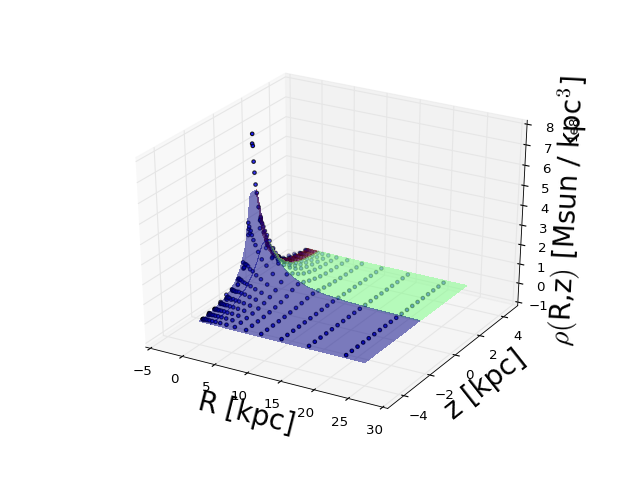

361
361
361


In [43]:
#%matplotlib qt
bins =20
x = np.logspace(-1,np.log10(25),bins)
y = np.linspace(-4,4,bins)
U= np.meshgrid(x, y)


Z = stars(U[0],U[1],m2.values['B_0'], m2.values['r0'], m2.values['al'] , m2.values['r_cut'],
          m2.values['q'], m2.values['D_0'], m2.values['z_d'], m2.values['Rd'])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

R_test = (x[1:] + x[:-1])/2
Z_test = (y[1:] + y[:-1])/2
X,Y = np.meshgrid(R_test, Z_test)
x_s = X.reshape(1,len(X)*len(X[0]))[0]
y_s = Y.reshape(1,len(Y)*len(Y[0]))[0]
dens = dens_hist.reshape(1,len(dens_hist)*len(dens_hist[0]))[0]
print len(x_s)
print len(y_s)
print len(dens)
ax.set_xlabel("R [kpc]",fontsize=25)
my_col = cm.jet(Z/Z.max())
ax.set_ylabel("z [kpc]",fontsize=25)
ax.set_zlabel(r"$\rho($R,z$)$ [Msun / kpc$^3$]",fontsize=25)

ax.scatter(x_s, y_s,dens,marker='.',s=40)
surf = ax.plot_surface(U[0], U[1], Z, cmap=cm.coolwarm, facecolors = my_col,alpha=0.5,
                       linewidth=0, antialiased=False)

In [44]:
print xedges

[  0.1          0.13372339   0.17881944   0.23912342   0.31976393
   0.42759916   0.57180008   0.76463044   1.02248972   1.36730789
   1.82841042   2.44501235   3.26955334   4.37215747   5.84659707
   7.81826764  10.45485231  13.98058264  18.69530866  25.        ]


<IPython.core.display.Javascript object>


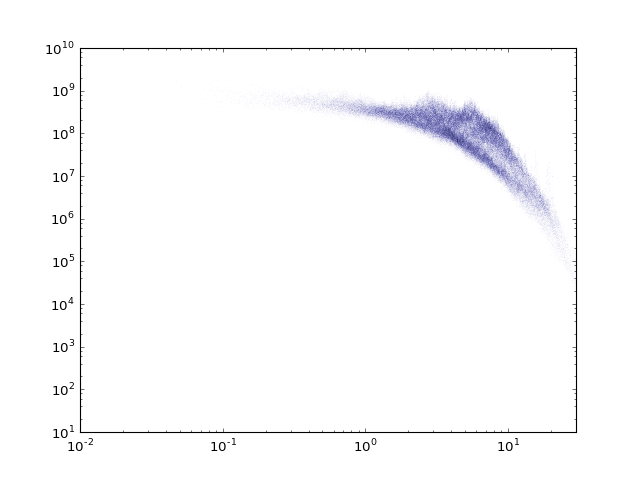

In [45]:
fig , ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01,30])
ax.scatter(myhalo.st.R[(myhalo.st.pos3d[:,2]<.2)&(myhalo.st.pos3d[:,2]>0)],
           rho_st[(myhalo.st.pos3d[:,2]<.2)&(myhalo.st.pos3d[:,2]>0)],s=0.01,lw=0)

In [46]:
print len(rho_st[(myhalo.st.pos3d[:,2]<.4)&(myhalo.st.pos3d[:,2]>0.2)&(myhalo.st.R<0.13)&(myhalo.st.R>0.1)])

43


# Gas


### histrogram


In [9]:
bins=20
edge = 25
zedge = edge/15
x_gs = np.logspace(-0.7,np.log10(edge),bins)
y_gs = np.linspace(-zedge,zedge,bins)
dens_hist_gs = np.zeros([len(y_gs)-1,len(x_gs)-1])
for i in range(len(x_gs[:-1])):
    for j in range(len(y_gs[:-1])):
        Rcon = (myhalo.gs.R >= x_gs[i] )&(myhalo.gs.R < x_gs[i+1] )
        Zcon = (myhalo.gs.pos3d[:,2] >= y_gs[j])&(myhalo.gs.pos3d[:,2] < y_gs[j+1])
        mass = np.sum(myhalo.gs.mass[np.where(Rcon&Zcon)])
        volume = np.pi * (y_gs[j+1]-y_gs[j]) * (x_gs[i+1]**2 - x_gs[i]**2)
        dens_hist_gs [j][i] = mass / volume 
    
    


In [10]:
print myhalo.gs.hsml.min()

0.151946


/usr/lib/python2.7/dist-packages/matplotlib/axes/_base.py:1327: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))
/usr/lib/python2.7/dist-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


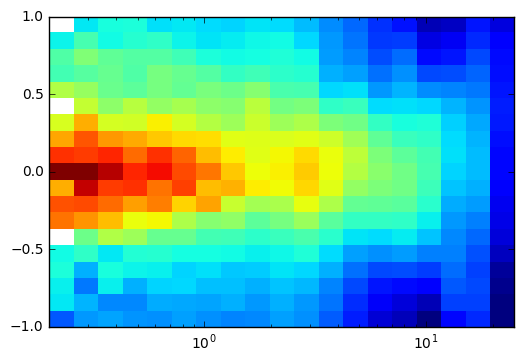

In [11]:

fig, ax = plt.subplots()
ax.set_xscale('log')
real =  plt.imshow(dens_hist_gs, interpolation='nearest', origin='low',norm=mpl.colors.LogNorm(),
           extent=[x_gs[0], x_gs[-1], y_gs[0], y_gs[-1]])

#cbar = plt.colorbar(real)#,orientation='horizontal')

In [25]:
def gas(R,z,D_0,z_d,Rm,Rd):
        
    return (10**D_0) * np.exp(- (Rm / R) - (R / Rd)) / (np.cosh(z /2./ z_d))**2


def gas(R,z,D_0,z_d,Rm,Rd):
        
    return (10**D_0) * np.exp( - (R / Rd)) / (np.cosh(z /2./ z_d))**2

R_array = (x_gs[1:] + x_gs[:-1])/2
Z_array = (y_gs[1:] + y_gs[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)


def chi2_gas(D_0,z_d,Rm,Rd):
    chi2_array =np.array([])
    expected = gas(R,Z,D_0,z_d,Rm,Rd)
    observed = dens_hist_gs
    c = ((observed)- (expected))**2
    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)


def mass_check_gas(D_0,z_d,Rm,Rd):
    bins = 101
    edge = 10
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-edge/15.,edge/15.,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * gas(U[0],U[1],D_0,z_d,Rm,Rd)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhalo.gs.mass[np.where((myhalo.gs.R<edge)&(np.abs(myhalo.gs.pos3d[:,2])<edge/15.))])
    
    diff = (np.log10(data_in) - np.log10(F))**2
    return  diff

In [26]:
mg1=Minuit(chi2_gas, 
         D_0=9.1,    error_D_0=0.01,     limit_D_0=(0,15),
         z_d=.01,  error_z_d=0.0001,  limit_z_d=(0.00,8),
         Rm=0.01,      error_Rm=0.0001,     limit_Rm=(0.00,6),
         Rd=3,     error_Rd=0.01,        limit_Rd=(0,20.),
         print_level=0)
mg1.migrad();

err = 0.2
upp = 1.2
low = 0.8
mg2=Minuit(mass_check_gas, 
         D_0=mg1.values['D_0'], error_D_0=mg1.values['D_0']*err, limit_D_0=(mg1.values['D_0']*low,mg1.values['D_0']*upp),
         z_d=mg1.values['z_d'], error_z_d=mg1.values['z_d']*err,  limit_z_d=(mg1.values['z_d']*low,mg1.values['z_d']*upp),
         Rm=mg1.values['Rm'], error_Rm=mg1.values['Rm']*err, limit_Rm=(mg1.values['Rm']*low,mg1.values['Rm']*upp + 0.0001),
         Rd=mg1.values['Rd'], error_Rd=mg1.values['Rd']*err, limit_Rd=(mg1.values['Rd']*low,mg1.values['Rd']*upp),
         print_level=0)

mg2.migrad();

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: InitialParamWarning: errordef is not given. Default to 1.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: InitialParamWarning: errordef is not given. Default to 1.


In [27]:
mg1.values

{'D_0': 9.592037954680809,
 'Rd': 0.5145725612459007,
 'Rm': 0.009999999999999898,
 'z_d': 0.05994751449637592}

In [28]:
mg2.values

{'D_0': 10.347911662313713,
 'Rd': 0.6000835801011737,
 'Rm': 0.009999999999999898,
 'z_d': 0.06307218819444453}

In [31]:
bins = 101
edge = 50

xe = np.linspace(0,edge,bins)
ye = np.linspace(-edge/15.,edge/15.,bins)
R_test = (xe[1:] + xe[:-1])/2
Z_test = (ye[1:] + ye[:-1])/2
U = np.meshgrid(R_test,Z_test)


def integrand(R,z,D_0,z_d,Rm,Rd):
    return 2. * np.pi * R * gas(R,z,D_0,z_d,Rm,Rd)

i = dblquad(integrand, -edge/15.,edge/15. , lambda x: 0, lambda x: edge, args=(mg2.values['D_0'], mg2.values['z_d'],mg2.values['Rm'], mg2.values['Rd']))

F = i[0]
print "Fit  =           {0:.5e}".format(F)
print "data =          ",np.sum(myhalo.gs.mass[np.where((myhalo.gs.R<edge)&(np.abs(myhalo.gs.pos3d[:,2])<edge/15.))])
print "data spherical= ",np.sum(myhalo.gs.mass[np.where(myhalo.gs.r<edge)])


Fit  =           1.27178e+10
data =           2.89035e+10
data spherical=  3.32988e+10


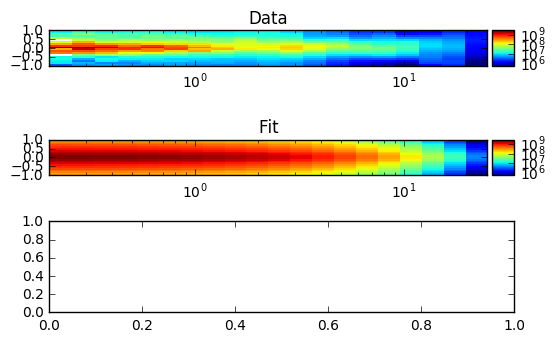

In [30]:


U = np.meshgrid(x_gs, y_gs)


Z = gas(U[0],U[1],mg2.values['D_0'], mg2.values['z_d'],mg2.values['Rm'], mg2.values['Rd'])


fig ,[ax,ax1,ax2] = plt.subplots(3,1)#,figsize=[6,12])
ax1.set_title("Fit")
ax.set_xscale('log')
ax1.set_xscale('log')
fit = ax1.imshow(Z, interpolation='nearest', origin='low',norm=mpl.colors.LogNorm(),
                  extent=[x_gs[0], x_gs[-1], y_gs[0], y_gs[-1]])
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)

ax.set_title("Data")

real = ax.imshow(dens_hist_gs, interpolation='nearest', origin='low',norm=mpl.colors.LogNorm(),
                  extent=[x_gs[0], x_gs[-1], y_gs[0], y_gs[-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')

361
361
361


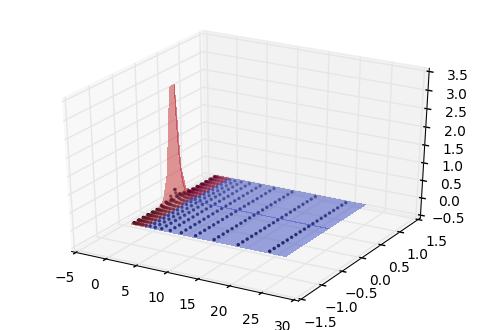

In [23]:
#%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
bins=30
edge = 30
xe = np.linspace(0,edge,bins)
ye = np.linspace(-edge/15.,edge/15.,bins)
R_test = (x_gs[1:] + x_gs[:-1])/2
Z_test = (y_gs[1:] + y_gs[:-1])/2
X,Y = np.meshgrid(R_test, Z_test)
x_s = X.reshape(1,len(X)*len(X[0]))[0]
y_s = Y.reshape(1,len(Y)*len(Y[0]))[0]
dens = dens_hist_gs.reshape(1,len(dens_hist_gs)*len(dens_hist_gs[0]))[0]
print len(x_s)
print len(y_s)
print len(dens)
ax.scatter(x_s, y_s,dens,marker='.',s=9)
surf = ax.plot_surface(U[0], U[1], Z, cmap=cm.coolwarm,alpha=0.5,
                       linewidth=0, antialiased=False)

# Dark Matter

In [7]:
hsml = myhalo.gs.hsml.min()

In [8]:
r_p = np.logspace(np.log10(3*hsml),np.log10(300),100)
hist,r = np.histogram(myhalo.dm.r,bins=r_p,weights=myhalo.dm.mass)
n_dm,r = np.histogram(myhalo.dm.r,bins=r_p)

vol = np.array([])
r1,r2 =r_p[:-1],r_p[1:]
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
profile = hist/vol
r = (r2+r1)/2.
rr = r

In [9]:
def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator

In [10]:
def chi2(po,r_s,al,be,ga):
    chi2_array =np.array([])
    expected = abg_profile(r,po,r_s,al,be,ga)
    observed = profile
    c = (np.log10((observed))- np.log10(expected))**2 / n
    chi2_array = np.append(chi2_array,c)
    return np.nansum(chi2_array)

In [11]:
mean = np.array([])
std = np.array([])
n=np.array([])
for i in range(len(r_p)-1):
    shell = np.where((myhalo.dm.r > r_p[i])&(myhalo.dm.r < r_p[i+1])&(myhalo.dm.r > hsml))
    n = np.append(n,len(shell[0]))
    mean = np.append(mean,np.mean(rho_dm[shell]))
    std = np.append(std,np.std(rho_dm[shell]))

In [15]:
"""
gammas = np.linspace(0.25,0.55,10)

for i in range(len(gammas)):
    m = Minuit(chi2, 
               po=8.0, error_po=0.01,     limit_po=(7.,11.),
               r_s=4.3,    error_r_s=0.01,     limit_r_s=(2.,8.),
               al=1.,     error_al=0.001,    limit_al=(0.1,5.5),
               be=2.3,  error_be=0.01,   limit_be=(0.01,3.5),
               ga=0.1,  error_ga=0.0001,   limit_ga=(gammas[i],3.),
               print_level=0)
    m.migrad();
    texto = " log_10(rho_0) = {1:.6f}, r_s = {2:0.3f} , alpha = {3:.3f} , beta = {4:.3f} ,  gamma = {5:.3f}".format(chi2_final_dm,m.values['po'],
                                                                                m.values['r_s'],m.values['al'],
                                                                                m.values['be'],m.values['ga'])
    chi2_final_dm = chi2(m.values['po'],m.values['r_s'],m.values['al'],m.values['be'],m.values['ga'])
    print texto
"""
    

'\ngammas = np.linspace(0.25,0.55,10)\n\nfor i in range(len(gammas)):\n    m = Minuit(chi2, \n               po=8.0, error_po=0.01,     limit_po=(7.,11.),\n               r_s=4.3,    error_r_s=0.01,     limit_r_s=(2.,8.),\n               al=1.,     error_al=0.001,    limit_al=(0.1,5.5),\n               be=2.3,  error_be=0.01,   limit_be=(0.01,3.5),\n               ga=0.1,  error_ga=0.0001,   limit_ga=(gammas[i],3.),\n               print_level=0)\n    m.migrad();\n    texto = " log_10(rho_0) = {1:.6f}, r_s = {2:0.3f} , alpha = {3:.3f} , beta = {4:.3f} ,  gamma = {5:.3f}".format(chi2_final_dm,m.values[\'po\'],\n                                                                                m.values[\'r_s\'],m.values[\'al\'],\n                                                                                m.values[\'be\'],m.values[\'ga\'])\n    chi2_final_dm = chi2(m.values[\'po\'],m.values[\'r_s\'],m.values[\'al\'],m.values[\'be\'],m.values[\'ga\'])\n    print texto\n'

In [16]:
Minuit?


In [45]:
m = Minuit(chi2, 
         po=8.0, error_po=0.01,     limit_po=(7.,11.),
         r_s=4.3,    error_r_s=0.01,     limit_r_s=(2.,8.),
         al=1.,     error_al=0.001,    limit_al=(0.1,5.5),
         be=3,  error_be=0.01,   limit_be=(0.01,3.5),
         ga=1,  error_ga=0.0001,   limit_ga=(0,3.))
m.migrad();

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: InitialParamWarning: errordef is not given. Default to 1.


FCN = 0.000389736554536 
 TOTAL NCALL = 387 
 NCALLS = 387 
 
 
 EDM = 4.44777863916e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 po 
 7.72576 
 2.3463 
 0 
 0 
 7.0 
 11.0 
 
 
 
 
 2 
 r_s 
 5.61511 
 3.66522 
 0 
 0 
 2.0 
 8.0 
 
 
 
 
 3 
 al 
 1.5761 
 2.78838 
 0 
 0 
 0.1 
 5.5 
 
 
 
 
 4 
 be 
 2.83733 
 1.79751 
 0 
 0 
 0.01 
 3.5 
 
 
 
 
 5 
 ga 
 0.0463071 
 2.24994 
 0 
 0 
 0.0 
 3.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & po & 7.726e+00 & 2.346e+00 & & & 7.000e+00 & 1.100e+01 & \\
\hline
2 & $r_{s}$ & 5.615e+00 & 3.665e+00 & & & 2.000e+00 & 8.000e+00 & \\
\hline
3 & al & 1.576e+00 & 2.788e+00 & & & 1.000e-01 & 5.500e+00 & \\
\hline
4 & be & 2.837e+00 & 1.798e+00 & & & 1.000e-02 & 3.500e+00 & \\
\hline
5 & ga & 4.631e-02 & 2.250e+00 & & & 0.000e+00 & 3.000e+00 & \\
\hline
\end{tabular}

In [46]:
chi2_final_dm = chi2(m.values['po'],m.values['r_s'],m.values['al'],m.values['be'],m.values['ga'])
print "chi2 = {0:.6f}".format(chi2_final_dm)
m.values


chi2 = 0.000390


{'al': 1.576096890826232,
 'be': 2.837331408805717,
 'ga': 0.04630706150131492,
 'po': 7.72576330768082,
 'r_s': 5.615108500401085}

<IPython.core.display.Javascript object>


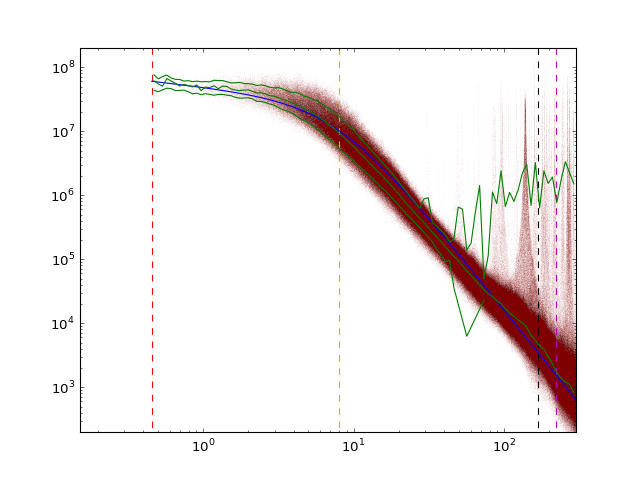

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in log10


In [13]:
fig, ax = plt.subplots()
ax.set_xlim([hsml,300])
ax.set_ylim([2e2,2e8])

y = np.logspace(1,9,20)
r200 = np.array([myhalo.r200 for i in y])
r97 = np.array([myhalo.r97 for i in y])
rsun = np.array([8 for i in y])
rhsml = np.array([hsml for i in y])
ax.plot(r200,y,'k--')
ax.plot(r97,y,'m--')
ax.plot(3*rhsml,y,'r--')
ax.plot(rsun,y,'y--')



ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(r_p,abg_profile(r_p,m.values['po'] ,m.values['r_s'],m.values['al'],m.values['be'],m.values['ga']))
mean_plus = mean+std
mean_minu = mean-std

ax.scatter(myhalo.dm.r,rho_dm,s=0.02,lw=0,alpha=0.6,c='r')
ax.plot(r[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')


ax.plot(r,hist/vol)

158659.808594


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in log10


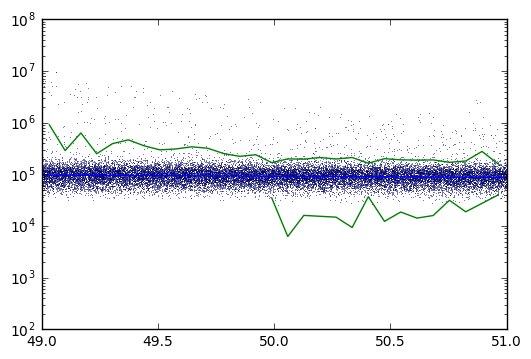

In [37]:
rmin,rmax = 49,51
r_slice =np.logspace(np.log10(rmin),np.log10(rmax),30)
mean_slice = np.array([])
std_slice = np.array([])
n_slice=np.array([])
for i in range(len(r_slice)-1):
    shell = np.where((myhalo.dm.r > r_slice[i])&(myhalo.dm.r < r_slice[i+1])&(myhalo.dm.r > hsml))
    n_slice = np.append(n_slice,len(shell[0]))
    mean_slice = np.append(mean_slice,np.mean(rho_dm[shell]))
    std_slice = np.append(std_slice,np.std(rho_dm[shell]))


mean_plus = mean_slice+std_slice
mean_minu = mean_slice-std_slice
r1,r2 =r_slice[:-1],r_slice[1:]

r_slice = (r2+r1)/2.

shell = (myhalo.dm.r>rmin)&(myhalo.dm.r<rmax)
fig, ax = plt.subplots()
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([rmin,rmax])
ax.scatter(myhalo.dm.r[shell],rho_dm[shell],s=0.3,lw=0,alpha=0.7)
ax.plot(r_slice[~np.isnan(np.log10(mean_plus))],mean_plus[~np.isnan(np.log10(mean_plus))],
        c='g')
ax.plot(r_slice[~np.isnan(np.log10(mean_minu))],mean_minu[~np.isnan(np.log10(mean_minu))],
        c='g')

ST = np.min(mean_plus)
print ST
ax.plot(rr,hist/vol)


In [40]:
fig, ax = plt.subplots()
ax.set_xlim([0.1,3])
ax.set_ylim([5e7,4e8])
hsml_1 = len(myhalo.dm.r[myhalo.dm.r<hsml])
y = np.logspace(np.log10(5e7),np.log10(4e8),20)
hsml_x = np.array([hsml for i in y]) 

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(hsml_x, y,'k--')
hsml_1 = len(myhalo.dm.r[myhalo.dm.r<hsml])
ax.text(0.68*hsml,3e8,"{0}\nparticles".format(hsml_1))
ax.plot(2*hsml_x, y,'k--')
hsml_1 = len(myhalo.dm.r[myhalo.dm.r<2*hsml])
ax.text(0.6*2*hsml,3e8,"{0}\nparticles".format(hsml_1))
ax.plot(3*hsml_x, y,'k--')
hsml_1 = len(myhalo.dm.r[myhalo.dm.r<3*hsml])
ax.text(0.68*3*hsml,3e8,"{0}\nparticles".format(hsml_1))

ax.plot(r_p,abg_profile(r_p,m.values['po'] ,m.values['r_s'],m.values['al'],m.values['be'],m.values['ga']))
ax.plot(r,hist/vol)
ax.scatter(myhalo.dm.r[myhalo.dm.r<3], rho_dm[myhalo.dm.r<3],s=0.1, lw=0,)

# velocity distribution

In [50]:
rmin,rmax = 7.5,8.5

shell = (myhalo.dm.r>rmin)&(myhalo.dm.r<rmax)
v = myhalo.dm.vel3d[shell]
local_vr = myhalo.dm.vr[shell]
local_vphi = myhalo.dm.vphi[shell]
local_vtheta = myhalo.dm.vtheta[shell]
local_vz = myhalo.dm.vel3d[shell,2]
local_v = myhalo.dm.v[shell]



<Container object of 54 artists>

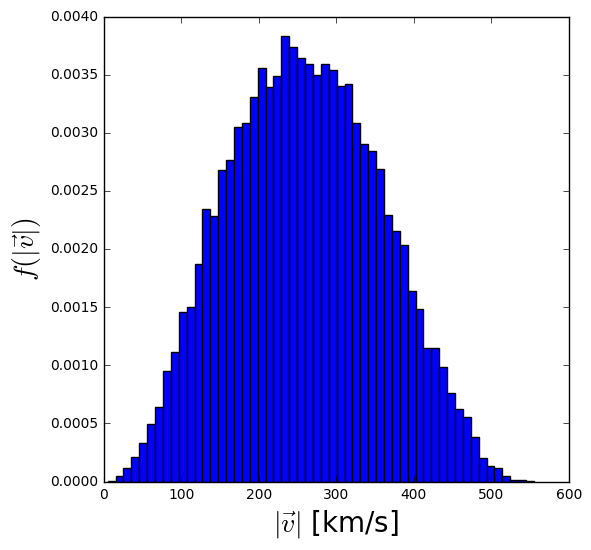

In [51]:
hist, bins = np.histogram(local_v,bins=np.linspace(-0,550,55),normed=True)
fig, ax =plt.subplots(figsize=[6,6])

ax.set_xlabel(r"$|\vec{v}|$ [km/s]", fontsize=20)
ax.set_ylabel(r"$f(|\vec{v}|)$", fontsize=20)
#ax.set_xlim([0,550])
#ax.set_ylim([0,0.0045])

size = bins[2]-bins[1]
bi = bins[:-1]+size/2
ax.bar(bi, hist, width=size)


In [32]:
hist, bins = np.histogram(local_vr,bins=np.linspace(-550,550,50),normed=True)
fig, ax =plt.subplots(figsize=[6,6])
ax.set_xlabel(r"$v_r$ [km/s]", fontsize=20)
ax.set_ylabel(r"$f(v_r)$", fontsize=20)
ax.set_xlim([-550,550])
ax.set_ylim([0,0.003])

size = bins[2]-bins[1]
bi = bins[:-1]+size/2
ax.bar(bi, hist, width=size)


<Container object of 49 artists>

<Container object of 47 artists>

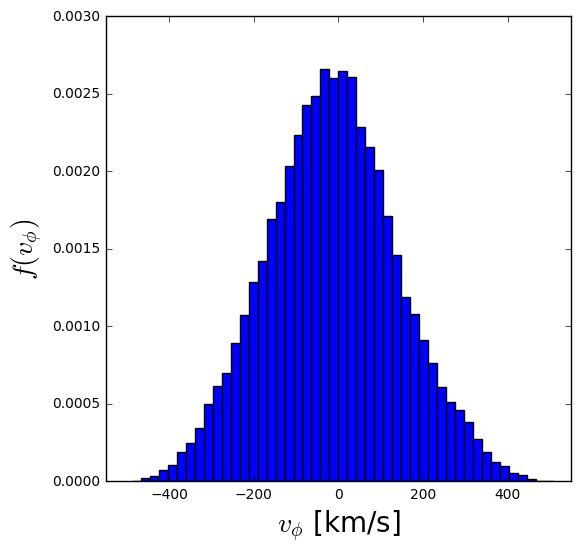

In [39]:
hist, bins = np.histogram(-local_vphi,bins=np.linspace(-500,500,48),normed=True)
fig, ax =plt.subplots(figsize=[6,6])
ax.set_xlabel(r"$v_{\phi}$ [km/s]", fontsize=20)
ax.set_ylabel(r"$f(v_{\phi})$", fontsize=20)
ax.set_xlim([-550,550])
ax.set_ylim([0,0.003])

size = bins[2]-bins[1]
bi = bins[:-1]+size/2
ax.bar(bi, hist, width=size)


<Container object of 47 artists>

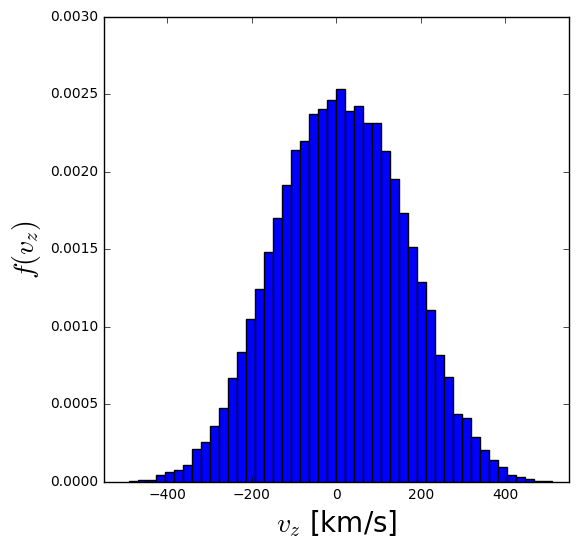

In [43]:
hist, bins = np.histogram(local_vz,bins=np.linspace(-500,500,48),normed=True)
fig, ax =plt.subplots(figsize=[6,6])
ax.set_xlabel(r"$v_{z}$ [km/s]", fontsize=20)
ax.set_ylabel(r"$f(v_{z})$", fontsize=20)
ax.set_xlim([-550,550])
ax.set_ylim([0,0.003])

size = bins[2]-bins[1]
bi = bins[:-1]+size/2
ax.bar(bi, hist, width=size)


In [44]:
hist, bins = np.histogram(local_vtheta,bins=np.linspace(-500,500,48),normed=True)
fig, ax =plt.subplots(figsize=[6,6])
ax.set_xlabel(r"$v_{\theta}$ [km/s]", fontsize=20)
ax.set_ylabel(r"$f(v_{\theta})$", fontsize=20)
ax.set_xlim([-550,550])
ax.set_ylim([0,0.003])

size = bins[2]-bins[1]
bi = bins[:-1]+size/2
ax.bar(bi, hist, width=size)


<Container object of 47 artists>

In [60]:

def overlap(ax,path,rmin,rmax,title="title"):
    v = np.array([])
    fv = np.array([])
    
    files = open(path)
    for line in files:
        row = line.split(' ')
        if np.isnan(float(row[3][:-1])):
            continue
        v = np.append(v,float(row[0]))
        fv = np.append(fv,float(row[3][:-1]))
    
    shell = (myhalo.dm.r>rmin)&(myhalo.dm.r<rmax)
    local_v = myhalo.dm.v[shell]
    hist, bins = np.histogram(local_v,bins=np.linspace(-0,v.max()*12/10,55),normed=True)
    ax.set_title(title,fontsize=18)
    ax.set_xlabel(r"$|\vec{v}|$ [km/s]", fontsize=20)
    ax.set_ylabel(r"$f(|\vec{v}|)$", fontsize=20)
    ax.text(np.mean(local_v)*0.5/10, fv.max()*1.03,r"mean = {0:.2f} km/s".format(np.mean(local_v)),fontsize=13)
    ax.set_xlim([0,bins.max()])
    ax.set_ylim([0,fv.max()*13/10])
    size = bins[2]-bins[1]
    bi = bins[:-1]+size/2
    ax.bar(bi, hist, width=size,label="f(v) ["+str(rmin)+"<r<"+str(rmax)+" kpc shell]")
    ax.plot(v,fv,'r',label="eddington")
    legend = ax.legend(loc='upper left', ncol=1, shadow=False,fontsize=13)

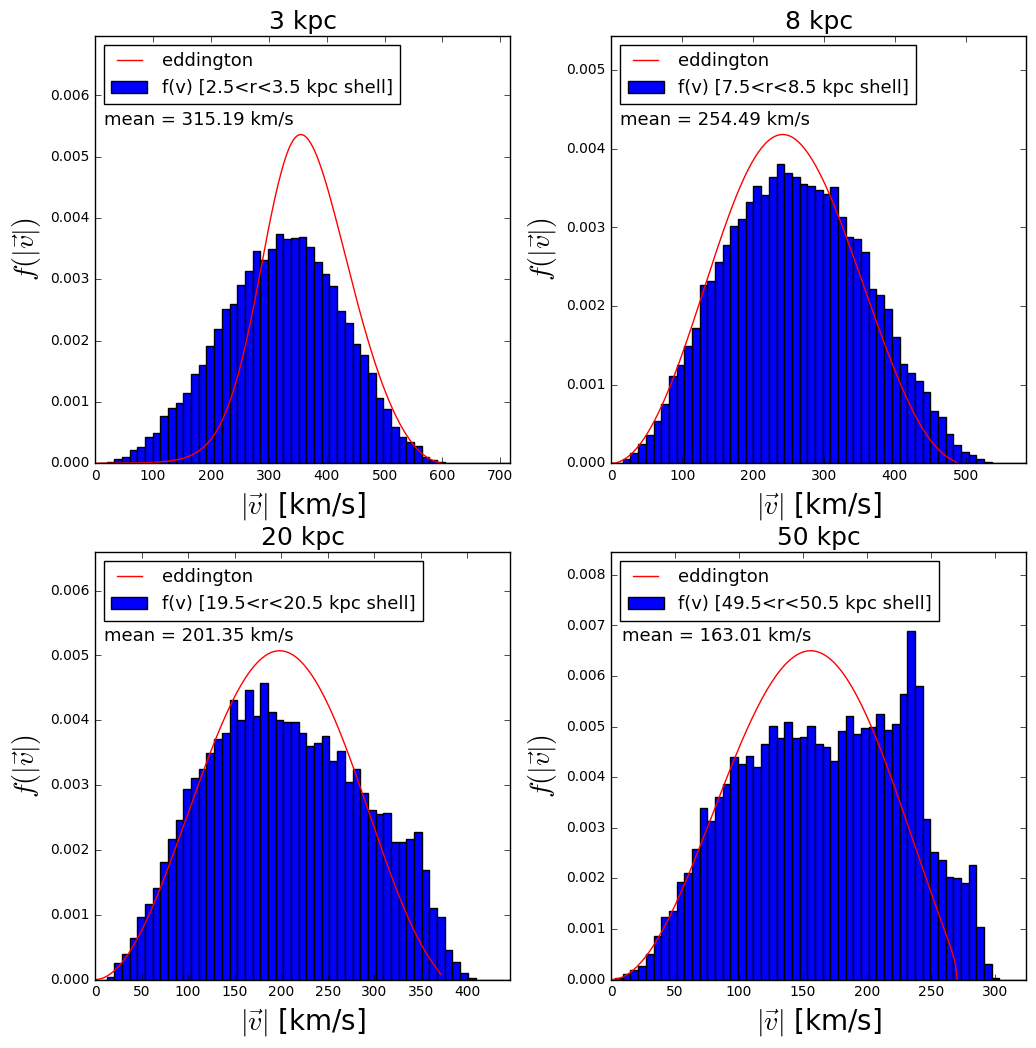

In [63]:
fig,[[ax,ax1],[ax2,ax3]]=plt.subplots(2,2,figsize=[10,10])
plt.tight_layout(h_pad=4.5,w_pad=4.5)
overlap(ax1,'/home/arturo/Downloads/fv_df0_model13_bar3_r8_rmax500_div0 (1).dat',
        7.5,8.5,title="8 kpc")
overlap(ax2,'/home/arturo/Downloads/fv_df0_model13_bar3_r20_rmax500_div0 (1).dat',
        19.5,20.5,title="20 kpc")
overlap(ax,'/home/arturo/Downloads/fv_df0_model13_bar3_r3_rmax500_div0 (1).dat',
        2.5,3.5,title="3 kpc")
overlap(ax3,'/home/arturo/Downloads/fv_df0_model13_bar3_r50_rmax500_div0 (1).dat',
        49.5,50.5,title="50 kpc")




In [85]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')
x,y = myhalo.st.pos3d[:,0],myhalo.st.pos3d[:,1]
cond = (myhalo.st.age<-4)# (myhalo.st.pos3d[:,2]<0)
ax.scatter(x[cond],y[cond],s=0.8,lw=0,c=rho_st[cond], cmap=cm,vmin=1e4, vmax=1e9)
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])

(-20, 20)

In [79]:
print myhalo.st.age.min(), myhalo.st.age.max()

-11.4479 5.82164e-05


In [27]:

v = np.array([])
fv = np.array([])

files = open('/home/arturo/Downloads/fv_df0_model11_bar4_r8_rmax500_div0.dat')
for line in files:
    row = line.split(' ')
    if np.isnan(float(row[3][:-1])):
        continue
    v = np.append(v,float(row[0]))
    fv = np.append(fv,float(row[3][:-1]))
    
rmin,rmax = 7,9
shell = (myhalo.dm.r>rmin)&(myhalo.dm.r<rmax)
local_v = myhalo.dm.v[shell]

In [13]:

v = np.array([])
fv = np.array([])

files = open('/home/arturo/Downloads/fv_df0_model13_bar3_r8_rmax500_div0 (1).dat')
for line in files:
    row = line.split(' ')
    if np.isnan(float(row[3][:-1])):
        continue
    v = np.append(v,float(row[0]))
    fv = np.append(fv,float(row[3][:-1]))
    
rmin,rmax = 7.5,8.5
shell = (myhalo.dm.r>rmin)&(myhalo.dm.r<rmax)
local_v = myhalo.dm.v[shell]

hist, bins = np.histogram(local_v,bins=np.linspace(-0,550,55),normed=True)
fig, ax =plt.subplots(figsize=[6,6])
ax.set_title("Halo B 8kpc")
ax.set_xlabel(r"$|\vec{v}|$ [km/s]", fontsize=20)
ax.set_ylabel(r"$f(|\vec{v}|)$", fontsize=20)
ax.text(np.mean(local_v)*0.5/10, hist.max()*12/10,r"mean = {0:.2f} km/s".format(np.mean(local_v)),fontsize=13)
print v[(fv==fv.max())][0]
ax.set_xlim([0,bins.max()])
ax.set_ylim([0,hist.max()*15/10])

size = bins[2]-bins[1]
bi = bins[:-1]+size/2
ax.bar(bi, hist, width=size,label=r"f(v) [19.5<r<20.5 kpc shell]")
ax.plot(v,fv,'r',label="eddington")
legend = ax.legend(loc='upper left', ncol=1, shadow=False,
                    fontsize=13)

241.454


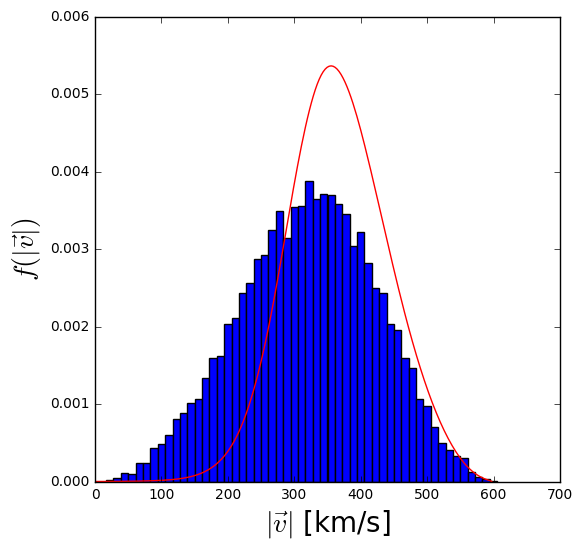

In [146]:

v = np.array([])
fv = np.array([])

files = open('/home/arturo/Downloads/fv_df0_model13_bar3_r3_rmax500_div0 (1).dat')
for line in files:
    row = line.split(' ')
    if np.isnan(float(row[3][:-1])):
        continue
    v = np.append(v,float(row[0]))
    fv = np.append(fv,float(row[3][:-1]))
    
rmin,rmax = 2.5,3.5
shell = (myhalo.dm.r>rmin)&(myhalo.dm.r<rmax)
local_v = myhalo.dm.v[shell]

hist, bins = np.histogram(local_v,bins=np.linspace(-0,600,55),normed=True)
fig, ax =plt.subplots(figsize=[6,6])

ax.set_xlabel(r"$|\vec{v}|$ [km/s]", fontsize=20)
ax.set_ylabel(r"$f(|\vec{v}|)$", fontsize=20)
#ax.set_xlim([0,550])
ax.set_ylim([0,0.006])

size = bins[2]-bins[1]
bi = bins[:-1]+size/2
ax.bar(bi, hist, width=size)
ax.plot(v,fv,'r')

average velocity = 199.70


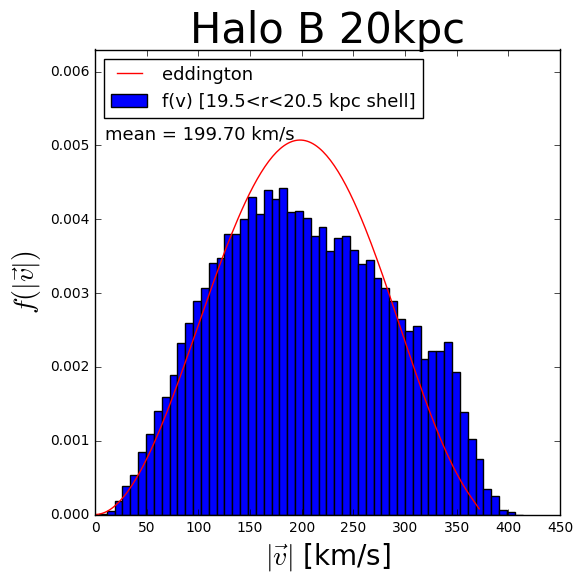

In [147]:

v = np.array([])
fv = np.array([])

files = open('/home/arturo/Downloads/fv_df0_model13_bar3_r20_rmax500_div0 (1).dat')
for line in files:
    row = line.split(' ')
    if np.isnan(float(row[3][:-1])):
        continue
    v = np.append(v,float(row[0]))
    fv = np.append(fv,float(row[3][:-1]))
    
rmin,rmax = 19.5,21.5
shell = (myhalo.dm.r>rmin)&(myhalo.dm.r<rmax)
local_v = myhalo.dm.v[shell]
print "average velocity = {0:.2f}".format(np.mean(local_v))
hist, bins = np.histogram(local_v,bins=np.linspace(-0,410,55),normed=True)
fig, ax =plt.subplots(figsize=[6,6])

ax.set_xlabel(r"$|\vec{v}|$ [km/s]", fontsize=20)
ax.set_ylabel(r"$f(|\vec{v}|)$", fontsize=20)
ax.set_xlim([0,450])
ax.set_ylim([0,0.0063])
ax.set_title("Halo B 20kpc", fontsize=30)
ax.text(np.mean(local_v)*0.5/10, hist.max()*11.5/10,r"mean = {0:.2f} km/s".format(np.mean(local_v)),fontsize=13)
size = bins[2]-bins[1]
bi = bins[:-1]+size/2
ax.bar(bi, hist, width=size,label=r"f(v) [19.5<r<20.5 kpc shell]")
ax.plot(v,fv,'r',label="eddington")
legend = ax.legend(loc='upper left', ncol=1, shadow=False,
                    fontsize=13)

In [148]:

v = np.array([])
fv = np.array([])

files = open('/home/arturo/Downloads/fv_df0_model13_bar3_r50_rmax500_div0 (1).dat')
for line in files:
    row = line.split(' ')
    if np.isnan(float(row[3][:-1])):
        continue
    v = np.append(v,float(row[0]))
    fv = np.append(fv,float(row[3][:-1]))
    
rmin,rmax = 49.5,50.5
shell = (myhalo.dm.r>rmin)&(myhalo.dm.r<rmax)&(rho_dm<ST)
local_v = myhalo.dm.v[shell]

hist, bins = np.histogram(local_v,bins=np.linspace(-0,310,55),normed=True)
fig, ax =plt.subplots(figsize=[6,6])

ax.set_xlabel(r"$|\vec{v}|$ [km/s]", fontsize=20)
ax.set_ylabel(r"$f(|\vec{v}|)$", fontsize=20)
#ax.set_xlim([0,550])
#ax.set_ylim([0,0.0045])
ax.set_title("Halo B 50kpc", fontsize=30)

size = bins[2]-bins[1]
bi = bins[:-1]+size/2
ax.bar(bi, hist, width=size)
ax.plot(v,fv,'r')